# Feature & Target Pipeline
Quick tests and evaluation on new targets/features/models

In [1]:
import pandas as pd
from pathlib import Path
from typing import Optional
import time
from data_pipeline import load_data  # This just loads the data and cleans it
from featureEngineer import FeatureEngineer
from targetEngineer import ExpirationTargetEngineer
from ML_setup import CONFIG
from ML_general_tools import *
from pathlib import Path

print("Imports and configuration ready")

# Build features, targets, and combined dataframe
t0 = time.time()
raw_history = load_data(CONFIG["data"]["path"])
print(f"Loaded raw data: {raw_history.shape} in {time.time()-t0:.2f}s")

# Use slice for faster testing (or use [:] for full data)
history_slice = raw_history[:]  # Last 3000 rows for faster testing
print(f"Using slice: {history_slice.shape}")

feature_params = dict(CONFIG["features"]["params"])
heavy_cache_cfg = CONFIG["features"].get("heavy_cache", {})
heavy_cache_root = Path(heavy_cache_cfg.get("directory", "cache/heavy_features"))

current_output_root_str = CONFIG["output"]["directory"]
current_output_root_path = Path(current_output_root_str)

paths = {
    "root": current_output_root_path,
    "feature_selection": current_output_root_path / CONFIG["output"]["subdirectories"]["features"],
    "trained_models": current_output_root_path / CONFIG["output"]["subdirectories"]["models"],
    "hpt_studies": current_output_root_path / CONFIG["output"]["subdirectories"]["hpt"],
    "feature_cache": current_output_root_path / CONFIG["output"]["subdirectories"]["cache"]
}

cache_dir = heavy_cache_root
cache_dir.mkdir(parents=True, exist_ok=True)
cache_files = sorted(cache_dir.glob("heavy_features_v*.pkl"))
cache_ready = bool(cache_files)
if cache_ready:
    print(f"Heavy cache ready: {cache_files[-1].name} (total {len(cache_files)}) in {cache_dir}")
else:
    print(f"No heavy cache file found in {cache_dir}; initial fit will populate.")

## Feature Engineering
fe = FeatureEngineer(verbose=True, **{k: v for k, v in feature_params.items() if k != "verbose"})

## Cache usage
cache_ready = bool(cache_files)  # Use actual cache status
cache_ready = False
manual_features = None
if cache_ready and fe.heavy_cache.load():
    print("\n✓ Using heavy cache (only prev_cycle features cached)")
    print("  Note: Rolling/stateless features still computed on-the-fly")
    t1 = time.time()
    fe._heavy_payload = fe.heavy_cache.payload
    reference = fe._prepare_reference_frame(history_slice)
    fe._full_reference = reference
    manual_features = fe._compute_all_features(reference, build_heavy=False)
    fe.feature_names_out_ = manual_features.columns.tolist()
    fe._reference_features = manual_features
    print(f"  Features computed in {time.time()-t1:.2f}s -> shape: {manual_features.shape}")
else:
    print("\n⚠ Heavy cache not available; running full fit (slower)")
    t1 = time.time()
    verbose_flag = feature_params.pop("verbose", False)
    fe = FeatureEngineer(verbose=True, **feature_params)
    fe.fit(history_slice)
    manual_features = fe.transform(history_slice)
    print(f"  Full fit+transform in {time.time()-t1:.2f}s -> shape: {manual_features.shape}")

feature_engineer = fe
features = manual_features.copy()

## 2a. Volatility Regime Target Engineering ---
from targetEngineer import VolatilityRegimeEngineer

print("\n--- Building Volatility Regime Targets ---")
t2 = time.time()

regime_engineer = VolatilityRegimeEngineer(
    lookback_window=24*3,    # 3 days lookback for vol
    seasonal_window=24*30,   # 30 days to learn patterns
    forward_window=24,       # 24h classification
    trend_std=1.2,           # 1.2 daily sigmas
    jump_std=3.0,            # 3.0 daily sigmas
    jump_speed_window=6,     # 6h window for jump detection
)

# Pass raw history (has OHLC) instead of features (doesn't have OHLC)
regime_engineer.fit(history_slice)
targets = regime_engineer.transform(history_slice)
print(f"Regime targets built in {time.time()-t2:.2f}s -> shape: {targets.shape}")

# Check distribution
dist = regime_engineer.get_regime_distribution(history_slice)
print("\nRegime distribution:")
print(dist)

# Combine
combined_df = pd.concat([features, targets], axis=1)
print(f"\nCombined shape: {combined_df.shape}")
print(f"Total pipeline time: {time.time()-t0:.2f}s")


/home/east/shared/eastSync/pyEast/pro_version/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports and configuration ready
=== Loading .hist_db_1h.csv ===

Initial rows: 53,963

=== FOUND ISSUES (prior to automated fixes) ===

🔴 TEMPORAL: Missing hours: 1 cases
  Missing timestamps sample:
    2025-11-04 13:00:00

🔴 DATA INTEGRITY: Identical consecutive OHLC rows: 174 cases
  Sample cases:
    {'o': '7110.10', 'h': '7110.10', 'l': '7110.10', 'c': '7110.10', 'volCcy': '0.00'}
    {'o': '7110.10', 'h': '7110.10', 'l': '7110.10', 'c': '7110.10', 'volCcy': '0.00'}
    {'o': '7110.10', 'h': '7110.10', 'l': '7110.10', 'c': '7110.10', 'volCcy': '0.00'}
  Affected dates (sample): 2020-01-02, 2020-01-03, 2020-01-04, 2020-01-05, 2020-01-06

=== APPLYING AUTOMATED FIXES ===
ACTION: Resampled/Reindexed to 53964 hourly intervals (was 53963).
ACTION: Forward-filled NaNs after resampling. (5 NaNs potentially filled by ffill).

=== FINAL STATUS (after automated fixes) ===
DataFrame shape post-fixes: (53964, 5) (Original: (53963, 6))
Date range: 2019-10-01 00:00:00 to 2025-11-26 11:00:00
No 

/shared/eastSync/pyEast/pro_version/featureEngineer.py:1585: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{vol_feat}_x_tte_sin"] = df[vol_feat] * df["tte_phase_sin"]
/shared/eastSync/pyEast/pro_version/featureEngineer.py:1587: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{vol_feat}_x_tte_cos"] = df[vol_feat] * df["tte_phase_cos"]
/shared/eastSync/pyEast/pro_version/featureEngineer.py:1575: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

[FeatureEngineer] feature build complete; rows=53964, cols=450, total=176.00s [stateless:268.0ms, merge_stateless:2.4ms, temporal:12.7ms, rolling:662.6ms, prev_week_cycle:165531.7ms, current_cycle:9062.3ms, non_linear:258.1ms, custom_interactions:28.8ms, cleanup:168.7ms]
[FeatureEngineer] fit complete; rows=53964, cols=450, elapsed=176.00s
[FeatureEngineer] transform start; rows=53964


/shared/eastSync/pyEast/pro_version/featureEngineer.py:1585: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{vol_feat}_x_tte_sin"] = df[vol_feat] * df["tte_phase_sin"]
/shared/eastSync/pyEast/pro_version/featureEngineer.py:1587: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{vol_feat}_x_tte_cos"] = df[vol_feat] * df["tte_phase_cos"]
/shared/eastSync/pyEast/pro_version/featureEngineer.py:1575: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

[FeatureEngineer] feature build complete; rows=53964, cols=450, total=10.32s [stateless:237.7ms, merge_stateless:4.3ms, temporal:13.2ms, rolling:659.5ms, prev_week_cycle:54.7ms, current_cycle:8895.1ms, non_linear:254.8ms, custom_interactions:29.0ms, cleanup:175.2ms]
[FeatureEngineer] transform complete; rows=53964, cols=450, elapsed=10.33s
  Full fit+transform in 186.32s -> shape: (53964, 450)

--- Building Volatility Regime Targets ---
Regime targets built in 340.26s -> shape: (53964, 6)
Regime targets built in 340.26s -> shape: (53964, 6)

Regime distribution:
regime_label
0    43805
1     6364
2     3795
Name: count, dtype: Int64

Combined shape: (53964, 456)
Total pipeline time: 869.62s

Regime distribution:
regime_label
0    43805
1     6364
2     3795
Name: count, dtype: Int64

Combined shape: (53964, 456)
Total pipeline time: 869.62s


In [3]:
import pickle
from pathlib import Path

# Define cache paths
cache_root = paths["root"]
cache_root.mkdir(parents=True, exist_ok=True)

feature_cache = cache_root / "features_cache.pkl"
target_cache = cache_root / "targets_cache.pkl"
combined_cache = cache_root / "combined_cache.pkl"

# Option 1: Load from cache if exists
FORCE_REBUILD = True  # Set to True to rebuild from scratch

if not FORCE_REBUILD and feature_cache.exists() and target_cache.exists():
    print("=" * 60)
    print("Loading cached features and targets...")
    t_load = time.time()
    
    with open(feature_cache, 'rb') as f:
        features = pickle.load(f)
    with open(target_cache, 'rb') as f:
        targets = pickle.load(f)
    with open(combined_cache, 'rb') as f:
        combined_df = pickle.load(f)
    
    print(f"✓ Loaded from cache in {time.time()-t_load:.2f}s")
    print(f"  Features: {features.shape}")
    print(f"  Targets: {targets.shape}")
    print(f"  Combined: {combined_df.shape}")
    print(f"  Date range: {features.index[0]} to {features.index[-1]}")
    print("=" * 60)
    
else:
    print("=" * 60)
    print("Cache not found or FORCE_REBUILD=True - will save after first run")
    print("To use cache next time:")
    print("  1. Run the first cell with history_slice = raw_history[:]")
    print("  2. Wait for features/targets to compute")
    print("  3. This cell will save them")
    print("  4. Next time, set FORCE_REBUILD=False and skip the first cell")
    print("=" * 60)
    
    # Save the current run to cache
    if 'features' in globals() and 'targets' in globals():
        print("\nSaving current features and targets to cache...")
        t_save = time.time()
        
        with open(feature_cache, 'wb') as f:
            pickle.dump(features, f)
        with open(target_cache, 'wb') as f:
            pickle.dump(targets, f)
        with open(combined_cache, 'wb') as f:
            pickle.dump(combined_df, f)
        
        print(f"✓ Saved to cache in {time.time()-t_save:.2f}s")
        print(f"  Location: {cache_root}")
    else:
        print("⚠ No features/targets to save yet - run the first cell first")


Cache not found or FORCE_REBUILD=True - will save after first run
To use cache next time:
  1. Run the first cell with history_slice = raw_history[:]
  2. Wait for features/targets to compute
  3. This cell will save them
  4. Next time, set FORCE_REBUILD=False and skip the first cell

Saving current features and targets to cache...
✓ Saved to cache in 0.44s
  Location: research_vol
✓ Saved to cache in 0.44s
  Location: research_vol


In [3]:
# Comprehensive NaN analysis in features
print("=" * 70)
print("NaN Analysis in Features")
print("=" * 70)

# 1. Overall NaN statistics
nan_counts = features.isna().sum()
nan_features = nan_counts[nan_counts > 0].sort_values(ascending=False)

print(f"\nTotal features: {len(features.columns)}")
print(f"Features with NaNs: {len(nan_features)}")
print(f"Total rows: {len(features)}")

# 2. Group NaN features by prefix to identify source
print("\n" + "=" * 70)
print("NaN Features Grouped by Source:")
print("=" * 70)

feature_groups = {}
for feat in nan_features.index:
    # Extract prefix (everything before first underscore or digit)
    if '_' in feat:
        prefix = feat.split('_')[0]
    else:
        prefix = 'other'
    
    if prefix not in feature_groups:
        feature_groups[prefix] = []
    feature_groups[prefix].append((feat, nan_counts[feat]))

# Sort groups by total NaN count
sorted_groups = sorted(feature_groups.items(), 
                       key=lambda x: sum(count for _, count in x[1]), 
                       reverse=True)

for prefix, features_list in sorted_groups[:10]:  # Top 10 groups
    total_nans = sum(count for _, count in features_list)
    print(f"\n{prefix.upper()} features: {len(features_list)} features, {total_nans:,} total NaNs")
    # Show top 5 within each group
    for feat, count in sorted(features_list, key=lambda x: x[1], reverse=True)[:5]:
        pct = (count / len(features)) * 100
        print(f"  {feat:50s} {count:6,} NaNs ({pct:5.2f}%)")

# 3. Analyze NaN patterns (start/middle/end)
print("\n" + "=" * 70)
print("NaN Location Analysis (Top 10 worst features):")
print("=" * 70)

for feat in nan_features.head(10).index:
    series = features[feat]
    nan_mask = series.isna()
    
    # Find first and last valid index
    valid_indices = series[~nan_mask].index
    if len(valid_indices) == 0:
        print(f"\n{feat}: ALL NaNs!")
        continue
    
    first_valid = valid_indices[0]
    last_valid = valid_indices[-1]
    
    # Count NaNs at start, middle, end
    start_nans = nan_mask.loc[:first_valid].sum() - 1  # -1 to exclude first valid
    end_nans = nan_mask.loc[last_valid:].sum() - 1  # -1 to exclude last valid
    middle_nans = nan_mask.sum() - start_nans - end_nans
    
    print(f"\n{feat}:")
    print(f"  Total NaNs: {nan_mask.sum():,} ({nan_mask.sum()/len(features)*100:.2f}%)")
    print(f"  Start NaNs: {start_nans:,} (before {first_valid})")
    print(f"  Middle NaNs: {middle_nans:,}")
    print(f"  End NaNs: {end_nans:,} (after {last_valid})")

# 4. Check specific feature types that are expected
print("\n" + "=" * 70)
print("Expected NaN Sources (prev_weekend, empirical, etc.):")
print("=" * 70)

prev_weekend_features = [f for f in nan_features.index if 'prev_saturday' in f or 'prev_sunday' in f]
empirical_features = [f for f in nan_features.index if 'emp_' in f]
prev_weekday_features = [f for f in nan_features.index if 'prev_weekday' in f]

print(f"\nprev_saturday/sunday features with NaNs: {len(prev_weekend_features)}")
if prev_weekend_features:
    for feat in prev_weekend_features[:5]:
        print(f"  {feat}: {nan_counts[feat]:,} NaNs")

print(f"\nemp_ (empirical) features with NaNs: {len(empirical_features)}")
if empirical_features:
    for feat in empirical_features[:5]:
        print(f"  {feat}: {nan_counts[feat]:,} NaNs")

print(f"\nprev_weekday features with NaNs: {len(prev_weekday_features)}")
if prev_weekday_features:
    for feat in prev_weekday_features[:5]:
        print(f"  {feat}: {nan_counts[feat]:,} NaNs")

# 5. Check which rows have NaNs
print("\n" + "=" * 70)
print("Row-wise NaN Analysis:")
print("=" * 70)

rows_with_nans = features.isna().any(axis=1)
print(f"Rows with ANY NaNs: {rows_with_nans.sum():,} / {len(features):,} ({rows_with_nans.sum()/len(features)*100:.2f}%)")

# Show first and last rows with NaNs
nan_row_indices = features[rows_with_nans].index
if len(nan_row_indices) > 0:
    print(f"First row with NaNs: {nan_row_indices[0]}")
    print(f"Last row with NaNs: {nan_row_indices[-1]}")
    
    # Count consecutive NaNs at start and end
    consecutive_start = 0
    for i in range(len(rows_with_nans)):
        if rows_with_nans.iloc[i]:
            consecutive_start += 1
        else:
            break
    
    consecutive_end = 0
    for i in range(len(rows_with_nans)-1, -1, -1):
        if rows_with_nans.iloc[i]:
            consecutive_end += 1
        else:
            break
    
    print(f"Consecutive NaN rows at start: {consecutive_start}")
    print(f"Consecutive NaN rows at end: {consecutive_end}")


NaN Analysis in Features

Total features: 450
Features with NaNs: 207
Total rows: 53964

NaN Features Grouped by Source:

VOL features: 53 features, 2,697 total NaNs
  vol_gkyz_288h_x_tte_sqrt                              288 NaNs ( 0.53%)
  vol_gkyz_288h_x_tte                                   288 NaNs ( 0.53%)
  vol_gkyz_288h_x_tte_cos                               288 NaNs ( 0.53%)
  vol_gkyz_288h_x_tte_sin                               288 NaNs ( 0.53%)
  vol_gkyz_288h_x_tte_sq                                288 NaNs ( 0.53%)

VLM features: 18 features, 597 total NaNs
  vlm_zscore_288h                                       144 NaNs ( 0.27%)
  vlm_ma_288h                                           144 NaNs ( 0.27%)
  vlm_zscore_144h                                        72 NaNs ( 0.13%)
  vlm_ma_144h                                            72 NaNs ( 0.13%)
  vlm_zscore_72h                                         36 NaNs ( 0.07%)

PRICE features: 7 features, 549 total NaNs
  price

In [4]:
# Clean combined dataframe - only drop start and end NaNs, preserve middle for debugging
# From analysis: 288 consecutive NaN rows at start, 0 at end

rows_with_nans = combined_df.isna().any(axis=1)

# Find first and last valid rows
valid_rows = ~rows_with_nans
valid_indices = combined_df[valid_rows].index

if len(valid_indices) > 0:
    first_valid = valid_indices[0]
    last_valid = valid_indices[-1]
    
    # Count start and end NaNs
    start_nans = rows_with_nans.loc[:first_valid].sum() - 1
    end_nans = rows_with_nans.loc[last_valid:].sum() - 1
    
    print(f"NaN Summary:")
    print(f"  First valid row: {first_valid}")
    print(f"  Last valid row: {last_valid}")
    print(f"  Start NaNs to drop: {start_nans}")
    print(f"  End NaNs to drop: {max(0, end_nans)}")
    
    # Slice from first valid to last valid (inclusive)
    combined_df_clean = combined_df.loc[first_valid:last_valid].copy()
    
    # Check for middle NaNs (these are preserved for inspection)
    middle_nans = combined_df_clean.isna().any(axis=1).sum()
    
    print(f"\nAfter trimming start/end:")
    print(f"  Rows: {len(combined_df_clean)} (from {combined_df_clean.index[0]} to {combined_df_clean.index[-1]})")
    print(f"  Middle rows with NaNs: {middle_nans}")
    
    if middle_nans > 0:
        print(f"  ⚠️ WARNING: {middle_nans} rows with NaNs in middle - preserved for debugging")
else:
    print("No valid rows found!")
    combined_df_clean = combined_df.iloc[0:0]  # Empty dataframe

combined_df_clean

NaN Summary:
  First valid row: 2019-10-13 00:00:00
  Last valid row: 2025-11-26 11:00:00
  Start NaNs to drop: 287
  End NaNs to drop: 0

After trimming start/end:
  Rows: 53676 (from 2019-10-13 00:00:00 to 2025-11-26 11:00:00)
  Middle rows with NaNs: 0


,o,h,l,c,volCcy,time_to_exp1_hr,time_elapsed,hour,day_of_week,is_weekend,...,skew_vol_extreme,kurtosis_vol_extreme,distance_vol_extreme,vol_surprise_clustering,regime_label,max_fwd_z_score,max_jump_z_score,box_std_deseasonalized,box_std_raw,seasonal_vol
2019-10-13 00:00:00,8308.5,8341.3,8289.9,8336.7,718.0,7.0,17.0,1,6,1,...,-0.361831,-0.141242,0.016816,-2.814803,0,0.687067,1.374134,0.006729,0.005135,0.003437
2019-10-13 01:00:00,8336.7,8368.5,8336.7,8349.9,796.0,6.0,18.0,2,6,1,...,-0.325121,-0.212071,0.015524,-0.215035,0,0.901515,1.803030,0.005487,0.005147,0.004225
2019-10-13 02:00:00,8350.0,8358.6,8340.0,8346.9,421.0,5.0,19.0,3,6,1,...,-0.329969,-0.205131,0.014965,0.169210,0,0.720972,1.441945,0.006759,0.005132,0.003420
2019-10-13 03:00:00,8346.9,8348.0,8340.0,8345.0,154.0,4.0,20.0,4,6,1,...,-0.330016,-0.225318,0.015040,-1.322802,0,0.638300,1.276600,0.007561,0.005110,0.003044
2019-10-13 04:00:00,8345.0,8363.4,8341.1,8341.7,576.0,3.0,21.0,5,6,1,...,-0.364801,-0.232202,0.015188,-3.175828,0,0.788462,1.576923,0.006019,0.005107,0.003822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-26 07:00:00,87725.2,87900.0,87637.7,87872.6,195.0,24.0,0.0,8,2,0,...,0.013903,-1.149395,0.028068,-1.972040,0,0.467373,0.000000,0.006393,0.005483,0.003863
2025-11-26 08:00:00,87872.7,87881.8,87342.9,87361.7,232.0,23.0,1.0,9,2,0,...,0.014572,-1.115242,0.026972,-6.318691,0,0.249501,0.000000,0.007204,0.005481,0.003427
2025-11-26 09:00:00,87353.5,87396.7,86627.9,86776.2,567.0,22.0,2.0,10,2,0,...,-0.054797,-1.139544,0.030126,-4.989376,0,0.092720,0.000000,0.005668,0.005495,0.004367
2025-11-26 10:00:00,86772.2,86999.9,86595.8,86879.7,195.0,21.0,3.0,11,2,0,...,-0.108033,-0.985923,0.033643,7.130272,0,0.017461,0.000000,0.008198,0.005503,0.003023


In [59]:
# Split into train/val/test (80/10/10)
n_samples = len(combined_df_clean)
train_end = int(n_samples * 0.8)
val_end = train_end + int(n_samples * 0.1)

# Get feature and target columns
feature_cols = features.columns.intersection(combined_df_clean.columns)
target_cols = targets.columns.intersection(combined_df_clean.columns)

X_train = combined_df_clean[feature_cols].iloc[:train_end]
X_val = combined_df_clean[feature_cols].iloc[train_end:val_end]
X_test = combined_df_clean[feature_cols].iloc[val_end:]

y_train = combined_df_clean[target_cols].iloc[:train_end]
y_val = combined_df_clean[target_cols].iloc[train_end:val_end]
y_test = combined_df_clean[target_cols].iloc[val_end:]

print(f"Split sizes:")
print(f"  Train: {len(X_train):,} rows ({len(X_train)/n_samples*100:.1f}%)")
print(f"  Val:   {len(X_val):,} rows ({len(X_val)/n_samples*100:.1f}%)")
print(f"  Test:  {len(X_test):,} rows ({len(X_test)/n_samples*100:.1f}%)")

print(f"\nX shapes -> train {X_train.shape}, val {X_val.shape}, test {X_test.shape}")
print(f"y shapes -> train {y_train.shape}, val {y_val.shape}, test {y_test.shape}")

# Final NaN check on all splits
train_nans = X_train.isna().sum().sum()
val_nans = X_val.isna().sum().sum()
test_nans = X_test.isna().sum().sum()

if train_nans + val_nans + test_nans == 0:
    print("\n✓ No NaNs in any split - ready for training!")
else:
    print(f"\n⚠ NaNs found:")
    if train_nans > 0:
        print(f"  Train: {train_nans} NaNs")
    if val_nans > 0:
        print(f"  Val: {val_nans} NaNs")
    if test_nans > 0:
        print(f"  Test: {test_nans} NaNs")

## now we drop future leaks, and add the rest as past features keeping only regime_label as target
# 1. Identify Columns
from numpy.lib.stride_tricks import sliding_window_view
price_cols = ['o', 'h', 'l', 'c']
vol_col = ['box_std_deseasonalized', 'box_std_raw', 'seasonal_vol']

## windowing for normalisation
rocket_window_size = 48
# add vol volumns to X from y_train
X_train_final = X_train.copy()
X_train_final[vol_col] = y_train[vol_col]

# create 3d views seperately for price and vol
X_price = X_train_final[price_cols].values
X_vol = X_train_final[vol_col].values

X_price_3d = sliding_window_view(X_price, window_shape=rocket_window_size, axis=0) # (N, 4, 48)
X_vol_3d = sliding_window_view(X_vol, window_shape=rocket_window_size, axis=0) # (N, 1, 48)

#Normalise prices per window (Z-score)
means = X_price_3d.mean(axis=2, keepdims=True)
stds = X_price_3d.std(axis=2, keepdims=True) + 1e-10 # avoid div by zero
X_price_norm = (X_price_3d - means) / stds


#Concatenate price and vol back
X_rocket_input = np.concatenate([X_price_norm, X_vol_3d], axis=1) 

# # 3. Fix y (Target)
target_col = 'regime_label'
y_train_final = y_train[target_col].astype(int)
y_train_aligned = y_train_final.iloc[rocket_window_size-1:].values.astype(int)

# Verify Shapes
print(f"ROCKET Input Shape: {X_rocket_input.shape}") 
# Should be: (~42893, 5, 48) -> (Samples, Channels, Time)
print(f"Target Shape:       {y_train_aligned.shape}") 
# Should be: (~42893,)



Split sizes:
  Train: 42,940 rows (80.0%)
  Val:   5,367 rows (10.0%)
  Test:  5,369 rows (10.0%)

X shapes -> train (42940, 450), val (5367, 450), test (5369, 450)
y shapes -> train (42940, 6), val (5367, 6), test (5369, 6)

✓ No NaNs in any split - ready for training!
ROCKET Input Shape: (42893, 7, 48)
Target Shape:       (42893,)


In [63]:
## train Rocekt + ridge
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from numpy.lib.stride_tricks import sliding_window_view

# transform X
rocket = MiniRocketMultivariate()
X_train_transformed = rocket.fit_transform(X_rocket_input)

# train clasifier
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), class_weight='balanced')
classifier.fit(X_train_transformed, y_train_aligned)
               
               


,alphas,array([1.0000...00000000e+03])
,fit_intercept,True
,scoring,None
,cv,None
,class_weight,'balanced'
,store_cv_results,False


In [64]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
rocket_window_size = 48
price_cols = ['c', 'h', 'l', 'o']
vol_cols = ['box_std_deseasonalized', 'box_std_raw', 'seasonal_vol']
target_col = 'regime_label'

def prepare_rocket_data(X_df, y_series=None):
    # 1. Move Vol Cols if needed
    X_temp = X_df.copy()
    if y_series is not None:
        X_temp[vol_cols] = y_series[vol_cols] # Ensure we have the vol context
    
    # 2. Windowing
    X_price = X_temp[price_cols].values
    X_vol = X_temp[vol_cols].values
    
    X_price_3d = sliding_window_view(X_price, window_shape=rocket_window_size, axis=0)
    X_vol_3d = sliding_window_view(X_vol, window_shape=rocket_window_size, axis=0)
    
    # 3. Normalization
    means = X_price_3d.mean(axis=2, keepdims=True)
    stds = X_price_3d.std(axis=2, keepdims=True) + 1e-10
    X_price_norm = (X_price_3d - means) / stds
    
    # 4. Concatenate
    X_input = np.concatenate([X_price_norm, X_vol_3d], axis=1)
    
    # 5. Align Y if provided
    y_aligned = None
    if y_series is not None:
        y_raw = y_series[target_col].astype(int)
        y_aligned = y_raw.iloc[rocket_window_size-1:].values
        
    return X_input, y_aligned

# --- EXECUTE PREP ON VALIDATION SET ---
# Assuming you have X_val and y_val from your earlier split
print("Preparing Validation Data...")
X_val_rocket_input, y_val_aligned = prepare_rocket_data(X_val, y_val)

print("Transforming with ROCKET (Inference)...")
# Note: Use .transform(), NOT .fit_transform()
X_val_features = rocket.transform(X_val_rocket_input)

print("Predicting...")
y_pred = classifier.predict(X_val_features)

Preparing Validation Data...
Transforming with ROCKET (Inference)...
Predicting...
Predicting...



=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    Chop (0)       0.86      0.65      0.74      4298
   Trend (1)       0.16      0.28      0.20       660
    Jump (2)       0.21      0.54      0.31       362

    accuracy                           0.60      5320
   macro avg       0.41      0.49      0.42      5320
weighted avg       0.73      0.60      0.65      5320



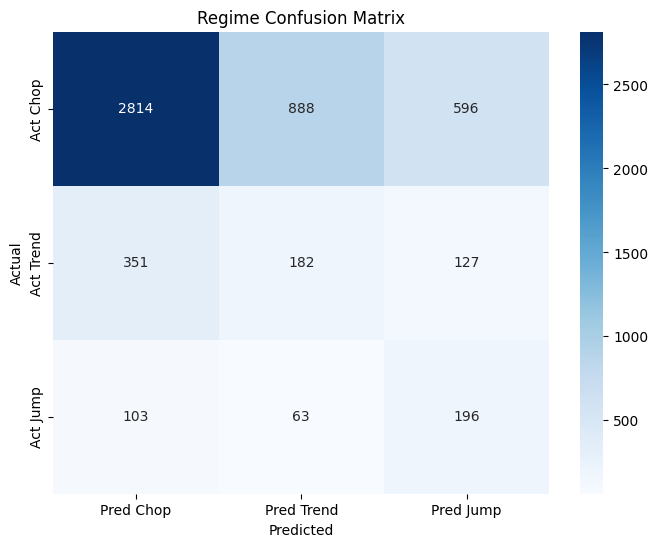

In [65]:
# 1. Classification Report
print("\n=== CLASSIFICATION REPORT ===")
# Target names map to 0, 1, 2
print(classification_report(y_val_aligned, y_pred, target_names=['Chop (0)', 'Trend (1)', 'Jump (2)']))

# 2. Confusion Matrix
cm = confusion_matrix(y_val_aligned, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Chop', 'Pred Trend', 'Pred Jump'],
            yticklabels=['Act Chop', 'Act Trend', 'Act Jump'])
plt.title("Regime Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [58]:

# 1. Generate Probs
# Note: X_train_final, X_val_final, X_test_final must have the raw columns
train_probs = get_rocket_probabilities(X_train, rocket, classifier)


train_probs


KeyError: "None of [Index(['box_std_deseasonalized', 'box_std_raw', 'seasonal_vol'], dtype='object')] are in the [columns]"

In [ ]:

val_probs = get_rocket_probabilities(X_val_final, rocket, classifier)
test_probs = get_rocket_probabilities(X_test_final, rocket, classifier)

# 2. Assign back to DataFrames
# Logic: The prediction at index `i` corresponds to the window ENDING at `i`.
# However, sliding_window_view reduces length by (window_size - 1).
# We must align indices correctly.

def add_probs_to_df(df, probs, window_size=48):
    # Create empty columns
    df['regime_prob_chop'] = np.nan
    df['regime_prob_trend'] = np.nan
    df['regime_prob_jump'] = np.nan
    
    # Alignment: The first prediction corresponds to the row at index (window_size - 1)
    # We assign the array to the end of the dataframe
    df.iloc[window_size-1:, df.columns.get_loc('regime_prob_chop')] = probs[:, 0]
    df.iloc[window_size-1:, df.columns.get_loc('regime_prob_trend')] = probs[:, 1]
    df.iloc[window_size-1:, df.columns.get_loc('regime_prob_jump')] = probs[:, 2]
    return df

# Apply
X_train_augmented = add_probs_to_df(X_train_final.copy(), train_probs)
X_val_augmented = add_probs_to_df(X_val_final.copy(), val_probs)
X_test_augmented = add_probs_to_df(X_test_final.copy(), test_probs)

print("Regime Probabilities added to dataset.")